# Import necessary libraries & set up the environment

In [2]:
!pip install datasets
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.1 MB/s eta 0:00:00


In [3]:
import random
import numpy as np
import torch
#carpeta donde voy a ir guardando los mejores modelos
from os import makedirs
import datetime
import numpy as np
import pandas as pd
from os import path

# install requirements
import sys
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    from google.colab import drive
    drive.mount('/content/drive')
    datasets_path = '/content/drive/MyDrive/TESIS/Datasets/VQA-VIZWIZ/annotations/'
    images_path = '/content/drive/MyDrive/TESIS/Datasets/VQA-VIZWIZ/'
    new_datasets_folder = '/content/drive/MyDrive/TESIS/VQA-MULTIMODEL_VIZWIZ/modelos/'
    makedirs(new_datasets_folder, exist_ok=True)


    !pip install -r '/content/drive/MyDrive/TESIS/Notebooks/VQA-MULTIMODAL-ESPAÑOL/requirements.txt'
else:
    !pip install -r requirements.txt
    datasets_path = '/content/drive/MyDrive/TESIS/Datasets/VQA-VIZWIZ/annotations/' #cambiarlo
    images_path = '/content/drive/MyDrive/TESIS/Datasets/VQA-VIZWIZ/' #cambiarlo
    new_datasets_folder = '/content/drive/MyDrive/TESIS/VQA-MULTIMODEL_VIZWIZ/modelos/' #cambiarlo
    makedirs(new_datasets_folder, exist_ok=True)





#poner randaugment en la misma carpeta donde esta la notebook

Running in Colab.
Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.2/79.2 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.5/287.5 kB 38.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 73.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.7/156.7 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.9/157.9 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.6/156.6 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 446.3/446.3 kB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.5/97.5 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━

##Esta habilitado CUDA?

In [4]:
#chekeo si cuda esta disponible
#torch.cuda.empty_cache()
print(torch.cuda.is_available())
!nvcc --version
if torch.cuda.is_available():
  print(torch.cuda.memory_summary(device=None, abbreviated=False))

True
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|-----

In [5]:
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

cuda
Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [6]:
# set seed and gpu requirements
SEED = 15
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [7]:
import os
from copy import deepcopy
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple
from datasets import load_dataset, set_caching_enabled
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from transformers import (
    # Preprocessing / Common
    AutoTokenizer, AutoFeatureExtractor,
    # Text & Image Models (Now, image transformers like ViTModel, DeiTModel, BEiT can also be loaded using AutoModel)
    AutoModel,
    # Training / Evaluation
    TrainingArguments, Trainer,
    # Misc
    logging
)

# import nltk
# nltk.download('wordnet')
from nltk.corpus import wordnet

from sklearn.metrics import accuracy_score, f1_score

In [8]:
# SET CACHE FOR HUGGINGFACE TRANSFORMERS + DATASETS
os.environ['HF_HOME'] = os.path.join(".", "cache")
# SET ONLY 1 GPU DEVICE
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

set_caching_enabled(True)
logging.set_verbosity_error()
logging.set_verbosity_info()

<ipython-input-8-5f7cdd75f293>:6: FutureWarning: set_caching_enabled is deprecated and will be removed in the next major version of datasets. Use datasets.enable_caching() or datasets.disable_caching() instead. This function will be removed in a future version of datasets.
  set_caching_enabled(True)


## Cargo los datasest

In [9]:
#Nombre de los datasets q voy a usar

data_train = "data_train_trad_GPT.csv"
data_vali ="data_eval_trad_GPT.csv"
data_ans =  "answer_space_trad_GPT.txt"
best_model_chekpoint = 'best_VQA_Multimodel_VIZWIZ_ES_GPT.pt'
metrics_log = 'metrics_GPT_log.csv'

In [10]:
#!cat {os.path.join(datasets_path, data_ans)}


In [11]:
dataset = load_dataset(
    "csv",
    data_files={
        "train": os.path.join(datasets_path,  data_train),
        "test": os.path.join(datasets_path, data_vali)
    }
)

with open(os.path.join(datasets_path, data_ans)) as f:
    answer_space = f.read().splitlines()

#with open(os.path.join(datasets_path, data_ans), encoding='latin-1') as f:
#    answer_space = f.read().splitlines()


print('Test len:', len(dataset['test']))
print('Train len: ',len(dataset['train']))

print('Train, question_trad mean len: ' ,np.mean([len(text.split(" ")) for text in dataset['train']['question_trad']]))
print('Train, answer_trad mean len: ' ,np.mean([len(text.split(" ")) for text in dataset['train']['answer_trad']]))
print('Train, question_trad std len: ' ,np.std([len(text.split(" ")) for text in dataset['train']['question_trad']]))
print('Train, answer_trad std len: ' ,np.std([len(text.split(" ")) for text in dataset['train']['answer_trad']]))
print('---------------------------------------------------')
print('Val , question_trad mean len: ' ,np.mean([len(text.split(" ")) for text in dataset['test']['question_trad']]))
print('Val, answer_trad mean len: ' ,np.mean([len(text.split(" ")) for text in dataset['test']['answer_trad']]))
print('Val , question_trad std len: ' ,np.std([len(text.split(" ")) for text in dataset['test']['question_trad']]))
print('Val, answer_trad std len: ' ,np.std([len(text.split(" ")) for text in dataset['test']['answer_trad']]))

print('answer_space mean len: ' ,np.mean([len(text.split(" ")) for text in answer_space]))

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Test len: 1525
Train len:  6100
Train, question_trad mean len:  5.754918032786885
Train, answer_trad mean len:  1.7101639344262296
Train, question_trad std len:  3.235930516058215
Train, answer_trad std len:  1.2393526758323141
---------------------------------------------------
Val , question_trad mean len:  5.815737704918033
Val, answer_trad mean len:  1.7101639344262296
Val , question_trad std len:  3.6298599796941065
Val, answer_trad std len:  1.3603019093572255
answer_space mean len:  2.276190476190476


Since we model this task as a multiclass classification task, we should assign labels to every answer. These labes are derived from the indices of the answers in the answer space.

In [12]:
dataset = dataset.map(
    lambda examples: {
        'label': [
            # Select the 1st answer if multiple answers are provided
            #answer_space.index(ans.replace(" ", "").split(",")[0])
            answer_space.index(ans)
            for ans in examples['answer_trad']
            #answer_space.index(ans.replace(" ", "").split(",")[0])
            #if ans.replace(" ", "").split(",")[0] in answer_space
            #else -1
            #for ans in examples['answer_trad']
        ]
    },
    batched=True
)

dataset

Map:   0%|          | 0/6100 [00:00<?, ? examples/s]

Map:   0%|          | 0/1525 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'image_id', 'width', 'height', 'answers', 'answer_grounding', 'question_trad', 'answer_trad', 'label'],
        num_rows: 6100
    })
    test: Dataset({
        features: ['question', 'answer', 'image_id', 'width', 'height', 'answers', 'answer_grounding', 'question_trad', 'answer_trad', 'label'],
        num_rows: 1525
    })
})

In [13]:

dataset['train'][0]

{'question': 'Is this card right side up or upside down? ',
 'answer': 'right side up',
 'image_id': 'VizWiz_train_00012487.jpg',
 'width': 1936,
 'height': 2592,
 'answers': "['downside up', 'sideways', 'right side up', 'right side up', 'up', 'neither', 'upside down', 'right side up', 'right side up', 'right side up']",
 'answer_grounding': "[{'y': 0.0, 'x': 16.94}, {'y': 20.736, 'x': 1101.1}, {'y': 2006.208, 'x': 1004.3}, {'y': 2006.208, 'x': 12.1}, {'y': 0.0, 'x': 16.94}]",
 'question_trad': '¿Esta carta está boca arriba o boca abajo?',
 'answer_trad': 'derecho arriba',
 'label': 1625}

# Create a Multimodal Collator for the Dataset

This will be used in the Trainer() to automatically create the Dataloader from the dataset to pass inputs to the model.

The collator will process the question (text) & the image, and return the tokenized text (with attention masks) along with the featurized image (basically, the pixel values). These will be fed into our multimodal transformer model for question answering.

We use AutoTokenizer and AutoFeatureExtractor from Hugging Face transformers to convert the raw images and questions into inputs for featurization using the respective image and text transformers.

In [14]:
from torchvision.transforms import Compose, Normalize, RandomResizedCrop, ColorJitter, ToTensor, RandomAffine, RandomRotation, InterpolationMode, ToPILImage
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,

)

%cd '/content/drive/MyDrive/TESIS/Notebooks/'
from randaugment import *

@dataclass
class MultimodalCollator:
    tokenizer: AutoTokenizer
    preprocessor: AutoFeatureExtractor


    def tokenize_text(self, texts: List[str]):
        encoded_text = self.tokenizer(
            text=texts,
            padding='longest',
            max_length=24,
            truncation=True,
            return_tensors='pt',
            return_token_type_ids=True,
            return_attention_mask=True,
        )
        return {
            "input_ids": encoded_text['input_ids'].squeeze(),
            "token_type_ids": encoded_text['token_type_ids'].squeeze(),
            "attention_mask": encoded_text['attention_mask'].squeeze(),
        }

    def preprocess_images(self, images: List[str], partition):
        # Agrego estas lineas para añadir data augmentation.
        #Pruebo con RandomResizedCrop: Crop a random portion of image and resize it to a given size y
        # ColorJitter: Randomly change the brightness, contrast, saturation and hue of an image
        #RandomRotation() rotates an image by a random angle. The chosen random angle is from a given range of angles in degree.
        #RandomRotation() transform accepts both PIL and tensor images.

        #size = (self.preprocessor.size["shortest_edge"] if "shortest_edge" in self.preprocessor.size else (self.preprocessor.size["height"], self.preprocessor.size["width"]))
            # hacemos un chequeo de que no entre cualquier cosa en vez de partition
        #assert self.partition in ['training', 'validation'], 'partition has to be training or validation, not {}'.format(partition)
        #data_transforms = [Normalize(mean=mean, std=std)]
        #print('mean: ' ,self.preprocessor.image_mean)
        #print('std: ', self.preprocessor.image_std)

        #mean=[0.485, 0.456, 0.406] # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
        #std=[0.229, 0.224, 0.225] # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
        mean =[0.48145466, 0.4578275, 0.40821073]
        std = [0.26862954, 0.26130258, 0.27577711]
        normalize = Normalize(mean=mean, std=std)
        #normalize = Normalize(mean=self.preprocessor.image_mean, std=self.preprocessor.image_std)
        #print('normalize: ', normalize)

        #print('crop_sizee: ', crop_size)

        if (partition == 'training'):
          #print('partition= ', partition)
          #normalize = Normalize(mean=self.preprocessor.image_mean, std=self.preprocessor.image_std)
          #shift = RandomAffine(degrees = 0, translate = (0.2, 0.2),interpolation=InterpolationMode.NEAREST)
          rand_rot_BIL1 = RandomRotation(degrees=[-35,35], interpolation=InterpolationMode.BILINEAR)
          #data_transforms = rand_rot_BIL1 + data_transforms
          #_transforms = rand_rot_BIL1 #, ToTensor(), normalize])
          #crop_images = RandomResizedCrop(crop_size)
          #data_transforms = [ColorJitter(brightness=0.5, hue=0.5)]
          #_transforms = Compose([crop_images,normalize]) #[rand_rot_BIL1, ColorJitter(brightness=0.5, hue=0.5)]) #, ToTensor(), normalize])
          #_transforms = Compose([Resize(255), CenterCrop(224),ToTensor(),normalize])
          #_transforms = Compose([Resize(255), CenterCrop(224),ColorJitter(brightness=0.5, hue=0.5), ToTensor()])
          #_transforms = Compose([Resize(255),ToTensor(),normalize,ToTensor()])
          #_transforms = Compose([Resize(224),rand_rot_BIL1,ToTensor(), normalize,ToPILImage()])

          #aplico solo normalizacion:
          #_transforms = Compose([ToTensor(),normalize, ToPILImage()])

          #_transforms = Compose([Resize((224, 224)),rand_rot_BIL1,ToTensor(),normalize, ToPILImage()])
          #_transforms = Compose([Resize((224, 224)),ToTensor(),normalize, ToPILImage()]) # resize, convert images to between 0 & 1 and normalize them

          #con data augmentation:
          '''
          _transforms = Compose([
            RandomResizedCrop(384,scale=(0.5, 1.0), interpolation=Image.BICUBIC),
            RandomHorizontalFlip(),
            randaugment.RandomAugment(2,7,isPIL=True,augs=['Identity','AutoContrast','Equalize','Brightness','Sharpness',
                                              'ShearX', 'ShearY', 'TranslateX', 'TranslateY', 'Rotate']),
            ToTensor(),
            normalize,
            ToPILImage()
        ])

          processed_images = self.preprocessor(
              images=[_transforms(Image.open(os.path.join(images_path, "images", image_id + ".jpg")).convert('RGB'))  for image_id in images],
              return_tensors="pt",)
          '''
          #sin data augmentatio:
          processed_images = self.preprocessor(
              images=[Image.open(os.path.join(images_path, "images", image_id + ".jpg")).convert('RGB')  for image_id in images],
              return_tensors="pt",)
        else:
          #print('partition= ', partition)

          #con data augmentation:
          '''
          #_transforms = Compose([Resize((224, 224)),ToTensor(),normalize, ToPILImage()])
          _transforms =Compose([Resize((384,384),interpolation=Image.BICUBIC),
          ToTensor(),
          normalize,
          ToPILImage()
          ])
          #_transforms = Compose([Resize(224),normalize,ToPILImage()])
          processed_images = self.preprocessor(
              images=[_transforms(Image.open(os.path.join(images_path, "images", image_id + ".jpg")).convert('RGB')) for image_id in images],
              return_tensors="pt",)
          '''
          #sin data augmentation:
          processed_images = self.preprocessor(
              images=[Image.open(os.path.join(images_path, "images", image_id + ".jpg")).convert('RGB') for image_id in images],
              return_tensors="pt",)

        return {
            "pixel_values": processed_images['pixel_values'].squeeze(),
        }

    def __call__(self, raw_batch_dict,partition):

        return {
            **self.tokenize_text(
                raw_batch_dict['question_trad'] #cambio por las questions traducidas
                if isinstance(raw_batch_dict, dict) else
                [i['question_trad'] for i in raw_batch_dict]
            ),
            **self.preprocess_images(
                raw_batch_dict['image_id']
                if isinstance(raw_batch_dict, dict) else
                [i['image_id'] for i in raw_batch_dict],partition
            ),
            'labels': torch.tensor(
                raw_batch_dict['label']
                if isinstance(raw_batch_dict, dict) else
                [i['label'] for i in raw_batch_dict],
                dtype=torch.int64
            ),
        }

/content/drive/MyDrive/TESIS/Notebooks


# Defining the Multimodal VQA Model Architecture

As mentioned previously, we use the idea of late fusion to define our multimodal model comprising:

* A text transformer to encode the question and generate embeddings
* An image transformer to encode the image and generate features
* A reasonably simple fusion layer that concatenates the textual and image features and passes them through a linear layer to generate an intermediate output
* A classifier, which is a fully connected network with output having the dimensions equal to that of the answer-space

Multimodal models can be of various forms to capture information from the text & image modalities, along with some cross-modal interaction as well. Here, we explore "Fusion" Models, that fuse information from the text encoder & image encoder to perform the downstream task (visual question answering).

The text encoder can be a text-based transformer model (like BERT, RoBERTa, etc.) while the image encoder could be an image transformer (like ViT, Deit, BeIT, etc.). After passing the tokenized question through the text-based transformer & the image features through the image transformer, the outputs are concatenated & passed through a fully-connected network with an output having the same dimensions as the answer-space.

Since we model the VQA task as a multi-class classification, it is natural to use the Cross-Entropy Loss as the loss function.

Posibles BERT model en Español en Hugging face:

'dccuchile/bert-base-spanish-wwm-cased' and

'dccuchile/bert-base-spanish-wwm-uncased'


In [15]:
#Clase que implementa el modelo: model es un objeto que implementa la clase abstracta torch.nn.Module, con el que se
#modela cualquier red neuronal o loss function.

class MultimodalVQAModel(nn.Module):
    def __init__(
            self,
            num_labels: int = len(answer_space),
            intermediate_dim: int = 512,
            #pretrained_text_name: str = 'bert-base-uncased',
            pretrained_text_name: str = 'dccuchile/bert-base-spanish-wwm-uncased',
            pretrained_image_name: str = 'google/vit-base-patch16-224-in21k'):

        super(MultimodalVQAModel, self).__init__()
        self.num_labels = num_labels
        self.pretrained_text_name = pretrained_text_name #text transformer
        self.pretrained_image_name = pretrained_image_name #image transformer

        self.text_encoder = AutoModel.from_pretrained(
            self.pretrained_text_name,
        )
        self.image_encoder = AutoModel.from_pretrained(
            self.pretrained_image_name,
        )
        #A reasonably simple fusion layer that concatenates the textual and image features and passes them through a linear
        #layer to generate an intermediate output
        self.fusion = nn.Sequential(
            nn.Linear(self.text_encoder.config.hidden_size + self.image_encoder.config.hidden_size, intermediate_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
        )

        self.classifier = nn.Linear(intermediate_dim, self.num_labels)

        self.criterion = nn.CrossEntropyLoss()

    def forward(
            self,
            input_ids: torch.LongTensor,
            pixel_values: torch.FloatTensor,
            attention_mask: Optional[torch.LongTensor] = None,
            token_type_ids: Optional[torch.LongTensor] = None,
            labels: Optional[torch.LongTensor] = None):

        encoded_text = self.text_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=True,
        )
        encoded_image = self.image_encoder(
            pixel_values=pixel_values,
            return_dict=True,
        )
        fused_output = self.fusion(
            torch.cat(
                [
                    encoded_text['pooler_output'],
                    encoded_image['pooler_output'],
                ],
                dim=1
            )
        )
        logits = self.classifier(fused_output)

        out = {
            "logits": logits
        }
        if labels is not None:
            loss = self.criterion(logits, labels) #aca estoy calculando la loss entre los output y los predicted
            out["loss"] = loss  #lo guardo en este parametro

        return out

# Define a Function to Create the Multimodal VQA Models along with their Collators
We plan to experiment with multiple pretrained text & image encoders for our VQA Model. Thus, we will have to create the corresponding collators along with the model (tokenizers, featurizers & models need to be loaded from same pretrained checkpoints)

In [16]:
def createMultimodalVQACollatorAndModel(text='dccuchile/bert-base-spanish-wwm-uncased', image='google/vit-base-patch16-224-in21k'):
    tokenizer = AutoTokenizer.from_pretrained(text)
    preprocessor = AutoFeatureExtractor.from_pretrained(image)

    multi_collator = MultimodalCollator(
        tokenizer=tokenizer,
        preprocessor=preprocessor,
    )


    multi_model = MultimodalVQAModel(pretrained_text_name=text, pretrained_image_name=image).to(device)
    return multi_collator, multi_model

#Metricas


In [17]:
#A simple pure-Python implementation would be:

import math
import re
from collections import Counter

WORD = re.compile(r"\w+")


def get_cosine(vec1, vec2):
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x] ** 2 for x in list(vec1.keys())])
    sum2 = sum([vec2[x] ** 2 for x in list(vec2.keys())])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator


def text_to_vector(text):
    words = WORD.findall(text)
    return Counter(words)


#text1 = "This is a foo bar sentence ."
#text2 = "This sentence is similar to a foo bar sentence ."
text1= 'esto es un ejemplo' #"salsa de arándanos"
text2= 'esto no es un ejemplo' #"salsa de arandanos"

vector1 = text_to_vector(text1)
vector2 = text_to_vector(text2)

cosine = get_cosine(vector1, vector2)

print("Cosine:", cosine)

Cosine: 0.8944271909999159


In [50]:
from typing import Dict, List, Optional, Tuple
import numpy as np
import nltk
nltk.download('wordnet')

%cd '/content/drive/MyDrive/TESIS/Notebooks/VQA-MULTIMODAL-ESPAÑOL/'

from calculate_wups import wup_measure

# Wrapper around the wup_measure(...) function to process batch inputs
def batch_wup_measure(labels, preds):
    #print('labels: ', labels)
    #print('preds: ', preds)
    cosine_scores = [get_cosine(text_to_vector(answer_space[label]), text_to_vector(answer_space[pred])) for label, pred in zip(labels, preds)]
    return np.mean(cosine_scores)

def batch_cosine_measure(labels, preds):
    wup_scores = [wup_measure(answer_space[label], answer_space[pred]) for label, pred in zip(labels, preds)]
    return np.mean(wup_scores)

# Function to compute all relevant performance metrics, to be passed into the trainer
def compute_metrics(eval_tuple: Tuple[np.ndarray, np.ndarray]) -> Dict[str, float]:
    preds, labels = eval_tuple
    #preds = logits.argmax(axis=-1)
    return {
        #"acc": accuracy_score(labels, preds),
        "cosine": batch_cosine_measure(labels, preds),
        "wups": batch_wup_measure(labels, preds)
    }

val_tuple= ([ 971, 1861,  971, 2816, 2251,  971, 2816, 2816,  971, 2816, 2816, 1194,
         971,  971, 2816, 2816],[ 971, 1131,   47, 1843, 2251,  805, 2991, 2710,  807, 1420, 1242, 1194,
         971, 1627,  994, 2456])
preds=torch.tensor([ 971, 1861,  971, 2816, 2251,  971, 2816, 2816,  971, 2816, 2816, 1194,
         971,  971, 2816, 2816], device='cuda:0').cpu().detach().numpy()
labels=torch.tensor([ 971, 1131,   47, 1843, 2251,  805, 2991, 2710,  807, 1420, 1242, 1194,
         971, 1627,  994, 2456], device='cuda:0').cpu().detach().numpy()

val_tuple= (preds,labels)
print(val_tuple)

#labels = torch.squeeze(labels)
#print(labels)
compute_metrics(val_tuple)

validation_metrics_per_batch= [{'cosine': 0.251875, 'wups': 0.25}, {'cosine': 0.1875, 'wups': 0.1875}, {'cosine': 0.0625, 'wups': 0.0625}, {'cosine': 0.2546875, 'wups': 0.25}, {'cosine': 0.125, 'wups': 0.125}, {'cosine': 0.25, 'wups': 0.25}]
cosine_scores = [get_cosine(text_to_vector(answer_space[label]), text_to_vector(answer_space[pred])) for label, pred in zip(labels, preds)]
np.mean(cosine_scores)


/content/drive/MyDrive/TESIS/Notebooks/VQA-MULTIMODAL-ESPAÑOL
(array([ 971, 1861,  971, 2816, 2251,  971, 2816, 2816,  971, 2816, 2816,
       1194,  971,  971, 2816, 2816]), array([ 971, 1131,   47, 1843, 2251,  805, 2991, 2710,  807, 1420, 1242,
       1194,  971, 1627,  994, 2456]))


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


{'cosine': 0.251875, 'wups': 0.25}

In [10]:
validation_metrics_per_batch= [{'cosine': 0.251875, 'wups': 0.25}, {'cosine': 0.1875, 'wups': 0.1875}, {'cosine': 0.0625, 'wups': 0.0625}, {'cosine': 0.2546875, 'wups': 0.25}, {'cosine': 0.125, 'wups': 0.125}, {'cosine': 0.25, 'wups': 0.25}]
cosine_scores_per_batch = np.mean([validation_metrics_per_batch[i]['cosine'] for i, val in enumerate(validation_metrics_per_batch)])
wups_scores_per_batch=np.mean([validation_metrics_per_batch[i]['wups'] for i, val in enumerate(validation_metrics_per_batch)])
validation_metrics_per_batch ={'cosine': cosine_scores_per_batch, 'wups': wups_scores_per_batch}
import numpy as np
print(validation_metrics_per_batch)


{'cosine': 0.18859375, 'wups': 0.1875}


In [19]:
validation_metrics_per_epoch =[{'wups': 123,'cosine':456},{'wups': 789,'cosine':123}]
validation_metrics_per_epoch[0]['wups']

texto=f'- Validation WUP: {validation_metrics_per_epoch[-1]}'
texto

round(validation_metrics_per_epoch[-1]['wups'],4)

789

In [20]:
!pip install thefuzz

from thefuzz import fuzz
print(fuzz.ratio("this is a test", "this is a test")/100)
print(fuzz.ratio("this is a test", "this is a test!")/100)
print(fuzz.ratio("this is a test", "this is no a test")/100)
print(fuzz.ratio("lapicero", "lapicera")/100)
print(fuzz.ratio("salsa de arándanos", "salsa de arandanos")/100)
print(fuzz.ratio("blanco", "negro")/100)
print('------')
print(fuzz.partial_ratio("this is a test", "this is a test")/100)
print(fuzz.partial_ratio("this is a test", "this is a test!")/100)
print(fuzz.partial_ratio("this is a test", "this is no a test")/100)
print(fuzz.partial_ratio("lapicero", "lapicera")/100)
print(fuzz.partial_ratio("salsa de arándanos", "salsa de arandanos")/100)
print(fuzz.partial_ratio("blanco", "negro")/100)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 10.5 MB/s eta 0:00:00
1.0
0.97
0.9
0.88
0.94
0.36
------
1.0
1.0
0.79
0.93
0.94
0.5


#Trianing loop
  def training_loop(n_epochs, optimizer, model, training_data, validation_data):

    - n_epochs: cantidad de veces que vamos a recorrer los datos de entrenamiento durante el entrenamiento.

    - optimizer: es un objeto del paquete torch.optim, que implementa un optimizador por gradiente descendente. Lo creamos fuera del loop, pasándole por parámetro la learning rate y los parámetros del modelo que queremos optimizar

    - model: es un objeto que implementa la clase abstracta torch.nn.Module, con el que se modela cualquier red neuronal o loss function.

    - training_data, validation_data: son objetos de la clase DataLoader del paquete torch.utils.data, que implementa el muestreo de los datos (armado de batches). Adentro, esas clases tienen objetos de la clase Dataset de torch.utils.data que implementan la lectura de los datos (ej. imagen y etiqueta)

In [53]:
# IMPLEMENTAR ACÁ EL TRAINING LOOP
def training_loop(start_epoch,n_epochs, scheduler, optimizer, model, train_loader, validation_loader, device, exp_name ,is_fully_connected=False):

  init = datetime.datetime.today()
  print('Init time: ', init)
  # inicializamos una lista de valores de loss por época
  training_loss_per_epoch = []
  validation_loss_per_epoch = []
  # e igual del accuracy
  training_accuracy_per_epoch = []
  validation_accuracy_per_epoch = []
  training_metrics_per_epoch =[]
  validation_metrics_per_epoch =[]

  # iteramos por cada época
  for epoch in range(start_epoch, n_epochs + 1):
    print('epoch: ',epoch)
    init_epoch = datetime.datetime.today()
    training_metrics_per_batch=[]
    validation_metrics_per_batch =[]
    # -----------------------------
    #          TRAINING
    # -----------------------------

    # inicializamos el valor de la loss en 0
    loss_train = 0.0
    # y la cantidad de valores totales y correctos (para calcular accuracy)
    total = 0
    correct = 0
    model.train()
    # for cada batch en nuestros datos de entrenamiento
    print('Training...')

    for batch in tqdm(train_loader):

        # get the inputs;
        batch = {k:v.to(device) for k,v in batch.items()}

        #me quedo con los labels para poder comparar mas adelante
        #labels = torch.argmax(batch["labels"],dim=-1)
        #labels = torch.squeeze(labels)
        #labels = labels.to(device=device)
        labels = batch['labels']
        #print('labels shape: ', labels.shape[0])

        # zero the parameter gradients
        #optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(**batch)

        logits = outputs["logits"] # training outputs
        #evaluamos la loss
        loss = outputs["loss"] #outputs.loss

        # limpiamos los gradientes anteriores
        optimizer.zero_grad()
        # calculamos los gradientes con backpropagation
        loss.backward()
        # actualizamos el optimizador
        optimizer.step()

        # y vamos sumando los valores de la loss
        loss_train += loss.item()

        # también podemos calcular el accuracy sobre datos de entrenamiento:
        # primero tenemos que estimar las etiquetas
        #_, predicted = torch.max(model.final_activation(outputs), dim=1)
        predictions =  torch.argmax(logits,dim=-1)
        #print('predictions: ', predictions)
        #print('labels: ', labels)

        # y después calculamos total de muestras y correctas
        #print('labels: ', batch["labels"].size()[0])
        total += labels.shape[0]
        correct += int((predictions == labels).sum())
        #train_tuple=(logits.argmax(axis=-1).cpu(), labels)
        #training_metrics_per_batch.append(compute_metrics(train_tuple))
        #print('correct: ', correct)
    # calculamos el promedio de la loss por época
    training_loss_per_epoch.append(loss_train / len(train_loader))
    # y el valor de accuracy
    training_accuracy_per_epoch.append(correct / total)
    #training_metrics_per_epoch.append(training_metrics_per_batch)

    # -----------------------------
    #         VALIDATION
    # -----------------------------

    # inicializamos el valor de la loss en 0
    loss_val = 0.0
    # y la cantidad de valores totales y correctos (para calcular accuracy)
    total = 0
    correct = 0
    model.eval()

    # como iteramos sobre los datos de validación, no calculamos gradientes
    with torch.no_grad():
      # for cada batch en nuestros datos de validación
      print('Validation...')
      for batch in tqdm(validation_loader):
        # get the inputs;
        batch = {k: v.to(device) for k,v in batch.items()}
        #me quedo con los labels
        #labels = torch.argmax(batch["labels"],dim=-1)
        #labels = torch.squeeze(labels)
        #labels = labels.to(device=device)
        labels = batch['labels']

        # obtenemos la rta del modelo
        outputs = model(**batch)
        logits = outputs["logits"]  #outputs.logits
        # evaluamos la loss
        loss = outputs["loss"] #outputs.loss

        #print("Loss:", loss.item())
        # y vamos sumando sus valores
        loss_val += loss.item()

        # estimamos las etiquetas
        predictions =  torch.argmax(logits,dim=-1)
        # y calculamos total de muestras y correctas
        total += labels.shape[0]
        correct += int((predictions == labels).sum())
        #val_tuple=(logits.argmax(axis=-1).cpu(), labels)
        #validation_metrics_per_batch.append(compute_metrics(val_tuple))
        #####################################
        #Calculo otra metrica que no sea ACC entre los datos predichos y los labels
        #####################################
        #primero tengo que convertir los tensoes en array de numpay para poder aplicarle las funciones de metricas:
        val_tuple=(predictions.cpu().detach().numpy(), labels.cpu().detach().numpy())
        validation_metrics_per_batch.append(compute_metrics(val_tuple))


    # calculamos el promedio de la loss por época
    validation_loss_per_epoch.append(loss_val / len(validation_loader))
    # y el valor de accuracy
    validation_accuracy_per_epoch.append(correct / total)

    #caculate mean metrics by batch to save it in each epoch:
    cosine_scores_per_batch = np.mean([validation_metrics_per_batch[i]['cosine'] for i, val in enumerate(validation_metrics_per_batch)])
    wups_scores_per_batch=np.mean([validation_metrics_per_batch[i]['wups'] for i, val in enumerate(validation_metrics_per_batch)])
    validation_metrics_per_batch ={'cosine': cosine_scores_per_batch, 'wups': wups_scores_per_batch}

    validation_metrics_per_epoch.append(validation_metrics_per_batch)

    ####################################
    #agrego esta linea para ir disminuyendo el lr
    curr_lr = optimizer.param_groups[0]['lr']
    print(f'LR: {curr_lr}')
    # Note that step should be called after validate()
    #scheduler.step(loss_val) #->lo comento cuando quiero usar un LR fijo
    ####################################

    # -----------------------------
    #    EARLY STOPPING
    # -----------------------------
    """
    Mas que early stopping es una implenetacion de almacenamiento de 2 modelos:
        * el ultimo
        * el de mejor accuracy en validacion
    """

    # guardamos el mejor modelo

    best_validation_accuracy =  max(validation_accuracy_per_epoch)

    if validation_accuracy_per_epoch[-1] == best_validation_accuracy:
        torch.save(model.state_dict(), path.join(new_datasets_folder, best_model_chekpoint))

    # guardamos el ultimo modelo
    #para coder retomar un entrenamiento desde un checkpoint tengo que guardar un par de cosas mas
    '''
    torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimazer_state_dict': optimizer.state_dict(),
                'loss': loss,
                'curr_lr': curr_lr
                },path.join(new_datasets_folder, f'last_VQA_Multimodel_VIZWIZ_finetunning_in_loop_ES.pt'))
    #torch.save(model.state_dict(), path.join(new_datasets_folder, f'last_ViLT_VIZWIZ_finetunning_in_loop.pt'))
    '''
    print('Best models saved')

    # -----------------------------
    #    IMPRIMIMOS RESULTADOS
    # -----------------------------

    text = f'[Epoch: {epoch}]:\t'
    text += f'- Training loss: {training_loss_per_epoch[-1]:.4f}.'
    text += f'- Validation loss: {validation_loss_per_epoch[-1]:.4f}'
    text += f'- Training accuracy: {training_accuracy_per_epoch[-1]}'
    text += f'- Validation accuracy: {validation_accuracy_per_epoch[-1]:.4f}'
    text +=f'- Validation WUP: {validation_metrics_per_epoch[-1]}'


    # cada 10 épocas, mostramos cuánto tardó la época y qué valor obtuvimos
    if epoch == 1 or epoch % 5 == 0:
        print(text+"\n")

    end_epoch = datetime.datetime.today()

    with open(path.join(new_datasets_folder, "log.log"), "a+") as log_file:
        log_file.write(f"[{end_epoch}]  {text}. Elapsed {(end_epoch - init_epoch).seconds / 60 :.1f} minutes.\n")

    #guardo las loss y accuracy en un df asi despues lo puedo usar para graficar
    loss_acc_data =[{'time': end_epoch,'epoch': epoch,'tr_loss':round(training_loss_per_epoch[-1],4),'val_loss':round(validation_loss_per_epoch[-1],4),
                     'tr_acc':round(training_accuracy_per_epoch[-1],4),
                     'val_acc':round(validation_accuracy_per_epoch[-1],4),
                     'val_wups':round(validation_metrics_per_epoch[-1]['wups'],4),
                     'val_cosine':round(validation_metrics_per_epoch[-1]['cosine'],4),
                     'curr_lr': str(curr_lr),'exp_name': exp_name}] #,'tr_metrics':round(training_metrics_per_epoch[-1],4),'val_metrics':round(validation_metrics_per_epoch[-1],4)}]
    loss_acc_df = pd.DataFrame(loss_acc_data)

    # append data frame to CSV file
    loss_acc_df.to_csv(new_datasets_folder + metrics_log, mode='a', index=False, header=False)


  end = datetime.datetime.today()
  with open(path.join(new_datasets_folder, "log.log"), "a+") as log_file:
    log_file.write(f"[{end_epoch}] FIN DEL TRAINING LOOP. Mejor modelo hallado en iteracion {np.argmax(validation_accuracy_per_epoch)+1}. Total elapsed {(end-init).seconds/60:.1f} minutos\n{'='*25}")


    # cada 10 épocas, mostramos cuánto tardó la época y qué valor obtuvimos
    #if epoch == 1 or epoch % 10 == 0:
    #  print('Epoch {}:'.format(epoch))
    #  print(' ---> Loss: Training {:.4f} - Validation {:.4f}'.format(training_loss_per_epoch[-1], validation_loss_per_epoch[-1]))
    #  print(' ---> Accuracy: Training {:.4f} - Validation {:.4f}'.format(training_accuracy_per_epoch[-1], validation_accuracy_per_epoch[-1]))

  # devolvemos los resultados
  return model, training_loss_per_epoch, validation_loss_per_epoch, training_accuracy_per_epoch, validation_accuracy_per_epoch

In [22]:
def get_num_parameters(model):
  '''
  Nos devuelve una lista con la cantidad de parámetros entrenables de un modelo
  '''
  # recuperamos todos los parámetros entrenables de la red
  numel_list = [p.numel()
                for p in model.parameters()
                if p.requires_grad == True]

  return numel_list

def countTrainableParameters(model):
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("No. of trainable parameters:\t{0:,}".format(num_params))

#EJECUCION

##Creacion de Dataloaders

Necesito crear un Python Dataloader.
We create a corresponding PyTorch DataLoader, which allows us to iterate over the dataset in batches.

- bertin-project/bertin-roberta-base-spanish: https://huggingface.co/bertin-project/bertin-roberta-base-spanish?text=Fui+a+la+librer%C3%ADa+a+comprar+un+%3Cmask%3E.

BERTIN is a series of BERT-based models for Spanish. The current model hub points to the best of all RoBERTa-base models trained from scratch on the Spanish portion of mC4 using Flax.





###Elijo los modelos que voy a usar

In [23]:
from torch.utils.data import DataLoader
from functools import partial

text_model='dccuchile/bert-base-spanish-wwm-uncased'  #-> BERT (Bidirectional Encoder Representations from Transformers) (BETO en español)
# 'bertin-project/bertin-roberta-base-spanish'
#-> RoBERTa (Robustly Optimized BERT Pretraining Approach) pero en español
#

image_model='google/vit-base-patch16-224-in21k'  #-> ViT (Vision Transformer):
#'microsoft/beit-base-patch16-224-pt22k-ft22k' #->BEiT (Bidirectional Encoder representation from Image Transformers):


collator, model = createMultimodalVQACollatorAndModel(text_model, image_model)

#con partial puedo pasarle parametros a la funcion call del MultimodalCollator y poder pasarle training o validation para que solo
#haga las transformaciones sobre los datos de training

train_dataloader = DataLoader(dataset['train'], collate_fn=partial(collator,partition='training'), batch_size=16, shuffle=True , num_workers=2)
val_dataloader = DataLoader(dataset['test'], collate_fn=partial(collator, partition='validation'), batch_size=16, shuffle=False , num_workers=2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/310 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--dccuchile--bert-base-spanish-wwm-uncased/snapshots/d1c9c4565c9d6731e57ed7f027b802697bad861e/config.json
Model config BertConfig {
  "_name_or_path": "dccuchile/bert-base-spanish-wwm-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.38.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 31002
}



vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/486k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--dccuchile--bert-base-spanish-wwm-uncased/snapshots/d1c9c4565c9d6731e57ed7f027b802697bad861e/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--dccuchile--bert-base-spanish-wwm-uncased/snapshots/d1c9c4565c9d6731e57ed7f027b802697bad861e/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--dccuchile--bert-base-spanish-wwm-uncased/snapshots/d1c9c4565c9d6731e57ed7f027b802697bad861e/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--dccuchile--bert-base-spanish-wwm-uncased/snapshots/d1c9c4565c9d6731e57ed7f027b802697bad861e/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--dccuchile--bert-base-spanish-wwm-uncased/snapshots/d1c9c4565c9d6731e57ed7f027b802697bad861e/co

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

loading configuration file preprocessor_config.json from cache at /root/.cache/huggingface/hub/models--google--vit-base-patch16-224-in21k/snapshots/b4569560a39a0f1af58e3ddaf17facf20ab919b0/preprocessor_config.json


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--vit-base-patch16-224-in21k/snapshots/b4569560a39a0f1af58e3ddaf17facf20ab919b0/config.json
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.38.2"
}

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
size shou

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--dccuchile--bert-base-spanish-wwm-uncased/snapshots/d1c9c4565c9d6731e57ed7f027b802697bad861e/pytorch_model.bin
Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--google--vit-base-patch16-224-in21k/snapshots/b4569560a39a0f1af58e3ddaf17facf20ab919b0/model.safetensors
All model checkpoint weights were used when initializing ViTModel.

All the weights of ViTModel were initialized from the model checkpoint at google/vit-base-patch16-224-in21k.
If your task is similar to the task the model of the checkpoint was trained on, you can already use ViTModel for predictions without further training.


Chequeo los batch que creó

In [24]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k, v.shape)


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


input_ids torch.Size([16, 20])
token_type_ids torch.Size([16, 20])
attention_mask torch.Size([16, 20])
pixel_values torch.Size([16, 3, 224, 224])
labels torch.Size([16])


In [25]:
batch_val = next(iter(val_dataloader))
for k,v in batch_val.items():
  print(k, v.shape)

input_ids torch.Size([16, 24])
token_type_ids torch.Size([16, 24])
attention_mask torch.Size([16, 24])
pixel_values torch.Size([16, 3, 224, 224])
labels torch.Size([16])


##Defino parametros para entrenar

Learning rate: For learning rates which are too low, the loss may decrease, but at a very shallow rate. When entering the optimal learning rate zone, you'll observe a quick drop in the loss function. Increasing the learning rate further will cause an increase in the loss as the parameter updates cause the loss to "bounce around" and even diverge from the minima. Remember, the best learning rate is associated with the steepest drop in loss, so we're mainly interested in analyzing the slope of the plot.

In [26]:
from tqdm.notebook import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

# determinamos el número de épocas por el que queremos entrenar
n_epochs = 50
start_epoch=1

# inicializamos un valor de learning rate
learning_rate = 5e-5 #2.5e-05  #1.25e-05 # 2.5e-5 #  ##1e-5  # # #5e-5 #5e-6 # #0.01#e-1 1e-5 #


# creamos una instancia de un optimizador
# pasándole los parámetros de nuestro modelo y la learning rate que queremos usar
LAMBDA = 1e-4 #L2 Regularization in PyTorch
optimizer = torch.optim.AdamW(model.parameters(), lr= learning_rate, weight_decay=LAMBDA)

##########################################
#agrego estas lineas para reducir el lr  when a metric has stopped improving.
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=0, verbose=True)
#scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=0, verbose=True)
#scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 2)
##########################################

# elegimos si usamos cuda o cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
is_fully_connected=False

# pedimos los parámetros del modelo que venimos usando antes
numel_list = get_num_parameters(model)

# imprimimos el número total de capas
print('parámetros del modelo:',sum(numel_list), numel_list)

parámetros del modelo: 198589157 [23809536, 393216, 1536, 768, 768, 589824, 768, 589824, 768, 589824, 768, 589824, 768, 768, 768, 2359296, 3072, 2359296, 768, 768, 768, 589824, 768, 589824, 768, 589824, 768, 589824, 768, 768, 768, 2359296, 3072, 2359296, 768, 768, 768, 589824, 768, 589824, 768, 589824, 768, 589824, 768, 768, 768, 2359296, 3072, 2359296, 768, 768, 768, 589824, 768, 589824, 768, 589824, 768, 589824, 768, 768, 768, 2359296, 3072, 2359296, 768, 768, 768, 589824, 768, 589824, 768, 589824, 768, 589824, 768, 768, 768, 2359296, 3072, 2359296, 768, 768, 768, 589824, 768, 589824, 768, 589824, 768, 589824, 768, 768, 768, 2359296, 3072, 2359296, 768, 768, 768, 589824, 768, 589824, 768, 589824, 768, 589824, 768, 768, 768, 2359296, 3072, 2359296, 768, 768, 768, 589824, 768, 589824, 768, 589824, 768, 589824, 768, 768, 768, 2359296, 3072, 2359296, 768, 768, 768, 589824, 768, 589824, 768, 589824, 768, 589824, 768, 768, 768, 2359296, 3072, 2359296, 768, 768, 768, 589824, 768, 589824, 76

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


## Entrenamos

VER EL CODIGO EN https://github.com/kyleseelman/vqa_accessibility/blob/main/ALBEF/Vizwiz.py
Para ver como usar el scheduler
La configuracion del scheduler y epocas esta en:
https://github.com/kyleseelman/vqa_accessibility/blob/main/ALBEF/configs/VQA.yaml


In [52]:
# entrenamos la red, usando los parámetros que arriba
print('#####Ejecutando con LR '+ str(learning_rate)+' y con Weight Decay ' +str(LAMBDA) +'#####')
exp_name ='BETO + VIT: ' + str(learning_rate) +'_WD='+ str(LAMBDA)
# 'ROBERTA+BeiT_LR='+ str(learning_rate)+'_WD='+ str(LAMBDA) +'_DA_randaugment'

modelo, tr_loss, val_loss, tr_acc, val_acc = training_loop(start_epoch, n_epochs,scheduler, optimizer, model, train_dataloader, val_dataloader, device, exp_name, is_fully_connected)

countTrainableParameters(modelo)


#####Ejecutando con LR 5e-05 y con Weight Decay 0.0001#####
Init time:  2024-04-14 21:02:03.595362
epoch:  1
Training...
Validation...


  0%|          | 0/96 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


validation_metrics_per_batch:  [{'cosine': 0.251875, 'wups': 0.25}]
validation_metrics_per_batch:  [{'cosine': 0.251875, 'wups': 0.25}, {'cosine': 0.1875, 'wups': 0.1875}]
validation_metrics_per_batch:  [{'cosine': 0.251875, 'wups': 0.25}, {'cosine': 0.1875, 'wups': 0.1875}, {'cosine': 0.0625, 'wups': 0.0625}]
validation_metrics_per_batch:  [{'cosine': 0.251875, 'wups': 0.25}, {'cosine': 0.1875, 'wups': 0.1875}, {'cosine': 0.0625, 'wups': 0.0625}, {'cosine': 0.2546875, 'wups': 0.25}]
validation_metrics_per_batch:  [{'cosine': 0.251875, 'wups': 0.25}, {'cosine': 0.1875, 'wups': 0.1875}, {'cosine': 0.0625, 'wups': 0.0625}, {'cosine': 0.2546875, 'wups': 0.25}, {'cosine': 0.125, 'wups': 0.125}]
validation_metrics_per_batch:  [{'cosine': 0.251875, 'wups': 0.25}, {'cosine': 0.1875, 'wups': 0.1875}, {'cosine': 0.0625, 'wups': 0.0625}, {'cosine': 0.2546875, 'wups': 0.25}, {'cosine': 0.125, 'wups': 0.125}, {'cosine': 0.25, 'wups': 0.25}]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


KeyboardInterrupt: 

##Plotting metrics

In [ ]:
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

file_path='/content/drive/MyDrive/TESIS/VQA-MULTIMODEL_VIZWIZ/modelos/'
metrics_log = 'metrics_log.csv'

colnames=['TIME', 'epoch', 'tr_loss', 'val_loss','tr_acc','val_acc','curr_lr','exp_name']
metrics_df = pd.read_csv(file_path + metrics_log ),names=colnames, header=None)
metrics_df



Mounted at /content/drive


,TIME,epoch,tr_loss,val_loss,tr_acc,val_acc,curr_lr,exp_name
0,2023-07-21 00:41:14.489094,1,5.5541,5.9748,0.0000,0.0000,NaN,NaN
1,2023-07-21 00:48:48.877566,2,5.1329,5.9960,0.0000,0.0000,NaN,NaN
2,2023-07-21 00:56:13.515448,3,4.7446,6.1163,0.0000,0.0000,NaN,NaN
3,2023-07-21 01:03:38.096799,4,4.3642,6.2205,0.0000,0.0000,NaN,NaN
4,2023-07-21 01:11:13.767083,5,4.0631,6.2628,0.0000,0.0000,NaN,NaN
...,...,...,...,...,...,...,...,...
643,2023-09-26 03:18:53.194424,28,2.4169,9.3459,0.5183,0.2361,2.5e-05,ROBERTA+BeiT_LR=2.5e-05_WD=0.0001_DA_randaugment
644,2023-09-26 03:25:34.905125,29,2.2349,9.6931,0.5506,0.2275,2.5e-05,ROBERTA+BeiT_LR=2.5e-05_WD=0.0001_DA_randaugment
645,2023-09-26 03:32:18.763745,30,2.0949,9.7846,0.5811,0.2374,2.5e-05,ROBERTA+BeiT_LR=2.5e-05_WD=0.0001_DA_randaugment
646,2023-09-26 03:39:00.961809,31,1.9382,10.0393,0.6132,0.2361,2.5e-05,ROBERTA+BeiT_LR=2.5e-05_WD=0.0001_DA_randaugment


In [ ]:
metrics_df[metrics_df.exp_name == 'ROBERTA+BeiT_LR=1.25e-05_WD=0.0001_DA+normalize+new_mean_std_bestLR'] [['val_acc', 'tr_acc']].mean()

#'ROBERTA+BeiT_LR=5e-05_WD=0.0001_base'][['val_acc', 'tr_acc']].mean()

val_acc    0.188912
tr_acc     0.643068
dtype: float64

In [ ]:
metrics_df.groupby('exp_name')['tr_acc','val_acc'].mean().reset_index().sort_values('val_acc',ascending=False)

<ipython-input-25-1f4cf26a18a9>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  metrics_df.groupby('exp_name')['tr_acc','val_acc'].mean().reset_index().sort_values('val_acc',ascending=False)


,exp_name,tr_acc,val_acc
11,ROBERTA+BeiT_LR=5e-05_WD=0.0001_base,0.755603,0.257069
5,ROBERTA+BeiT_LR=2.5e-05_WD=0.0001_DA+normalize...,0.435560,0.222012
16,ROBERTA+VIT_LR=5e-05_WD=0.0001_DA,0.230222,0.200444
3,ROBERTA+BeiT_LR=1.25e-05_WD=0.0001_DA+normaliz...,0.643068,0.188912
1,LR=5e-06_WD=0.0001,0.208350,0.181565
7,ROBERTA+BeiT_LR=2.5e-05_WD=0.0001_DA_randaugment,0.306619,0.180816
6,ROBERTA+BeiT_LR=2.5e-05_WD=0.0001_DA+normalize...,0.290253,0.174321
8,ROBERTA+BeiT_LR=5e-05_WD=0.0001_DA+normalize+L...,0.253719,0.173019
14,ROBERTA+BeiT_LR=5e-06_WD=5e-06_DA+normalize+LR...,0.235659,0.171055
12,ROBERTA+BeiT_LR=5e-05_WD=0.0001_normalize,0.279340,0.156410


In [ ]:
metrics_df_filter =metrics_df[616:]

metrics_df_filter = metrics_df_filter.drop_duplicates(subset=['epoch'], keep='last')
metrics_df_filter

,TIME,epoch,tr_loss,val_loss,tr_acc,val_acc,curr_lr,exp_name
616,2023-09-26 00:14:05.860259,1,7.2232,6.6357,0.0492,0.0603,2.5e-05,ROBERTA+BeiT_LR=2.5e-05_WD=0.0001_DA_randaugment
617,2023-09-26 00:21:04.529776,2,6.5189,6.4248,0.0782,0.0957,2.5e-05,ROBERTA+BeiT_LR=2.5e-05_WD=0.0001_DA_randaugment
618,2023-09-26 00:27:58.525395,3,6.4511,6.6462,0.0923,0.1003,2.5e-05,ROBERTA+BeiT_LR=2.5e-05_WD=0.0001_DA_randaugment
619,2023-09-26 00:34:52.675585,4,6.3049,6.7162,0.1017,0.1095,2.5e-05,ROBERTA+BeiT_LR=2.5e-05_WD=0.0001_DA_randaugment
620,2023-09-26 00:41:40.234273,5,6.1060,6.7112,0.1159,0.1089,2.5e-05,ROBERTA+BeiT_LR=2.5e-05_WD=0.0001_DA_randaugment
621,2023-09-26 00:48:38.488259,6,5.9044,6.4631,0.1340,0.1416,2.5e-05,ROBERTA+BeiT_LR=2.5e-05_WD=0.0001_DA_randaugment
622,2023-09-26 00:55:20.501782,7,5.6453,6.6946,0.1487,0.1285,2.5e-05,ROBERTA+BeiT_LR=2.5e-05_WD=0.0001_DA_randaugment
623,2023-09-26 01:02:07.220933,8,5.4951,6.5620,0.1584,0.1567,2.5e-05,ROBERTA+BeiT_LR=2.5e-05_WD=0.0001_DA_randaugment
624,2023-09-26 01:08:53.091211,9,5.3024,6.6797,0.1777,0.1548,2.5e-05,ROBERTA+BeiT_LR=2.5e-05_WD=0.0001_DA_randaugment
625,2023-09-26 01:15:41.983613,10,5.1640,6.7660,0.1838,0.1633,2.5e-05,ROBERTA+BeiT_LR=2.5e-05_WD=0.0001_DA_randaugment


In [ ]:
tr_loss_list = metrics_df_filter['tr_loss'].to_list()
val_loss_list = metrics_df_filter['val_loss'].to_list()
tr_acc_list = metrics_df_filter['tr_acc'].to_list()
val_acc_list = metrics_df_filter['val_acc'].to_list()
curr_lr_list=metrics_df_filter['curr_lr'].to_list()

In [ ]:
def plot_training_statistics(training_loss_per_epoch, validation_loss_per_epoch, training_accuracy_per_epoch, validation_accuracy_per_epoch):
  '''
  Plotea las estadísticas sobre datos de entrenamiento y validación
  (loss function y valores de accuracy)
  '''

  # creamos plots para la loss y el accuracy
  fig, axes = plt.subplots(1, 2, figsize=(10, 5))
  # graficamos la evolución de la loss de entrenamiento y la de validación
  axes[0].plot(training_loss_per_epoch, color='blue')
  axes[0].plot(validation_loss_per_epoch, color='red')
  axes[0].set_xlabel('Epochs')
  axes[0].set_ylabel('loss')
  axes[0].grid(True)
  axes[0].legend(['Training set', 'Validation set'])
  axes[0].set_title('Loss function ')
  # graficamos la evolución del accuracy en los datos de entrenamiento y validación
  axes[1].plot(training_accuracy_per_epoch, color='blue')
  axes[1].plot(validation_accuracy_per_epoch, color='red')
  axes[1].set_xlabel('Epochs')
  axes[1].set_ylabel('Accuracy')
  axes[1].grid(True)
  axes[1].legend(['Training set', 'Validation set'])
  axes[1].set_title('Accuracy')
  axes[1].set_ylim([0, 1.0])
  fig.tight_layout(pad=3.0)

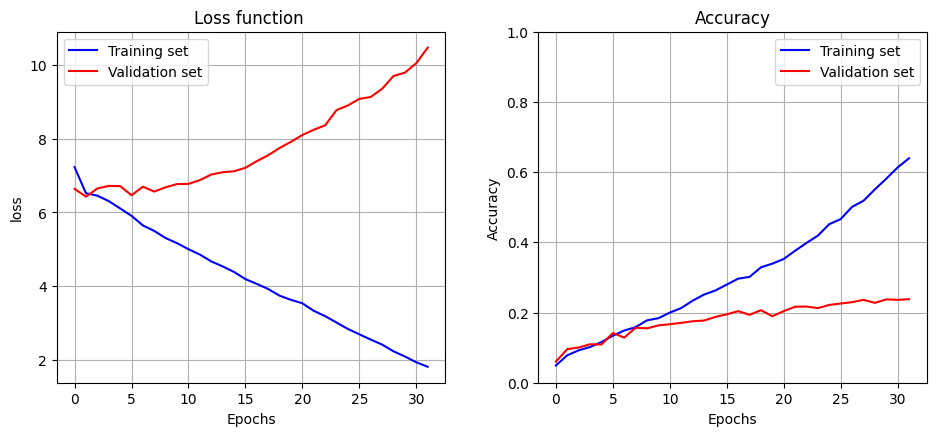

In [ ]:
import matplotlib.pyplot as plt

plot = plot_training_statistics(tr_loss_list, val_loss_list, tr_acc_list, val_acc_list)

### Busqueda del mejor LR
Learning rate vs loss plot

<Axes: xlabel='curr_lr'>

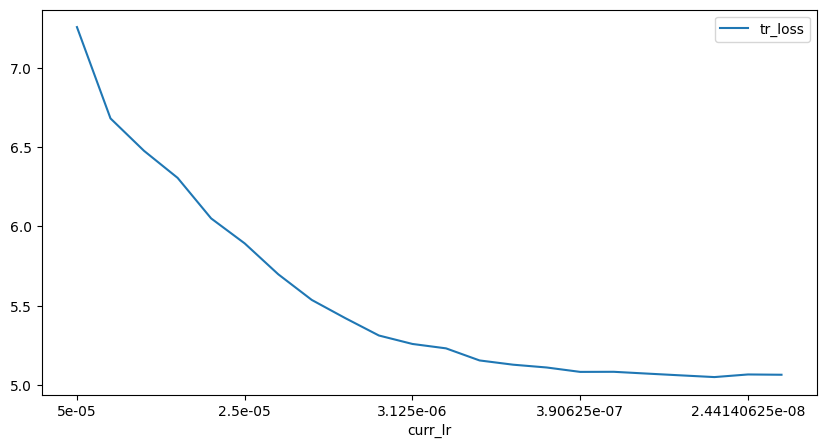

In [ ]:
metrics_df_filter.plot(x='curr_lr', y='tr_loss',figsize=(10, 5))
#plt.xscale('log')

Another way to look at these numbers is calculating the rate of change of the loss (a derivative of the loss function with respect to iteration number), then plot the change rate on the y-axis and the learning rate on the x-axis.

In [ ]:
import matplotlib.pyplot as plt
def plot_loss_change(learn_list, sma=1, n_skip=20, y_lim=(-0.01,0.01)):
    """
    Plots rate of change of the loss function.
    Parameters:
        learn_list - lista de LRs #learning rate scheduler, an instance of LR_Finder class.
        sma - number of batches for simple moving average to smooth out the curve.
        n_skip - number of batches to skip on the left.
        y_lim - limits for the y axis.
    """
    derivatives = [0] * (sma + 1)
    for i in range(1 + sma, len(learn_list)):
        derivative = (float(learn_list.iloc[i]) - float(learn_list.iloc[i - sma])) / sma
        #print(i)
        #print(float(learn_list.iloc[i]) )
        #print(i - sma)
        #print(float(learn_list.iloc[i - sma]))
        #print(learn_list.iloc[i])
        #print('derivative: ',derivative)
        derivatives.append(derivative)

    plt.ylabel("d/loss")
    plt.xlabel("learning rate (log scale)")

    plt.figure().set_figwidth(15)
    plt.plot(learn_list.iloc[n_skip:], derivatives[n_skip:])
    #plt.plot(learn_list, derivatives)
    #plt.xscale('log')
    #plt.ylim(y_lim)



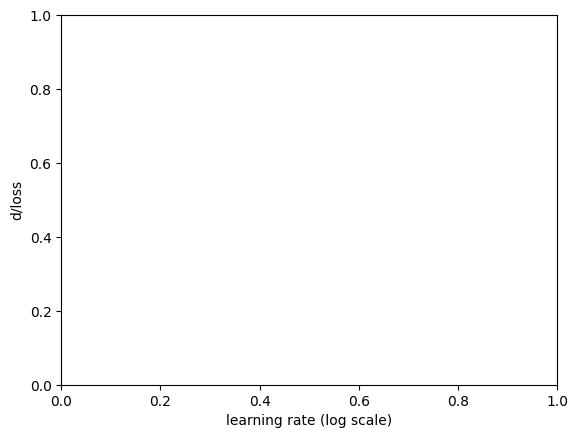

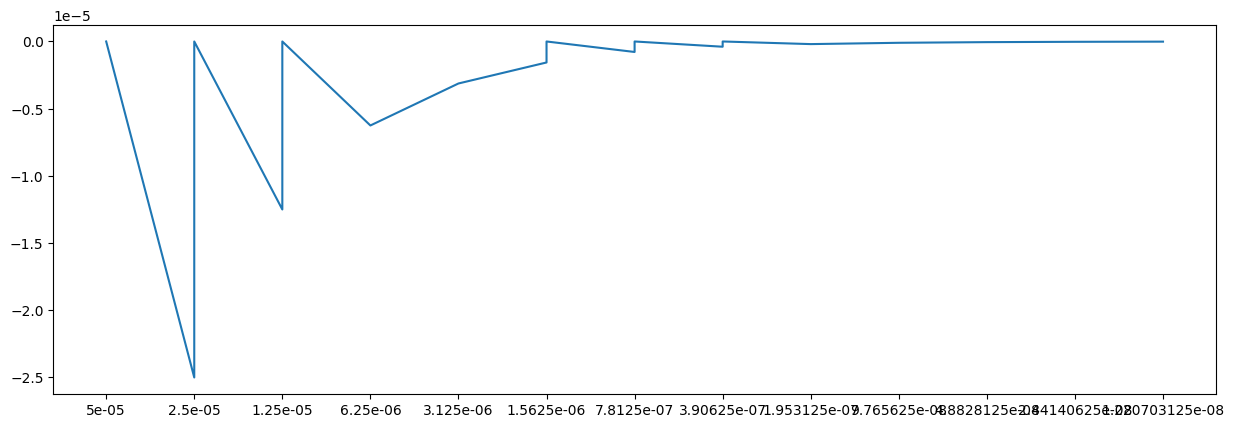

In [ ]:
curr_lr_df=metrics_df_filter['curr_lr']
#print(len(curr_lr_df))
plot_loss_change(curr_lr_df, n_skip=0,sma=1)